In [13]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB

from sklearn.metrics import f1_score, precision_score, recall_score, make_scorer

from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

from functools import reduce

import matplotlib.pyplot as plt

In [14]:
data = pd.read_json('../input/annamayya-song-lyrical-map/song_lyric_map.json')
# Labels
lbls = ['Devotional','Romantic']

In [15]:
RAND_STATE = 42
TEST_SIZE = 0.3
WORD_CNT_THRESH = 10
CV_LEVELS = [5,10]

In [16]:
freq = pd.Series(' '.join(data['Lyric']).split()).value_counts()
def filter_low_freq_words(s,f):
    return ' '.join([x for x in s.split() if f[x]>WORD_CNT_THRESH])
data.Lyric = data.Lyric.apply(lambda x:filter_low_freq_words(x,freq))

In [17]:
X=data['Lyric']
y=data['Genre']

In [18]:
count_vector = CountVectorizer()
X_counts = count_vector.fit_transform(X)
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [19]:
def do_grid_search(_X,_y,mdl,params,scoring,key,n=5):
    est = GridSearchCV(mdl,params,scoring=scoring,cv=n,return_train_score=True,refit=key,n_jobs=-1)
    est.fit(_X,_y)
    return est

In [20]:
def plot_grid_results(est,keys,title):
    plt.figure(figsize=[12,3])
    plt.suptitle(title)
    for i,k in enumerate(keys):
        train_score = reduce(lambda a,b: list(a) + list(b), [est.cv_results_[f'split{x}_train_{k}'] for x in range(est.cv)])
        test_score = reduce(lambda a,b: list(a) + list(b), [est.cv_results_[f'split{x}_test_{k}'] for x in range(est.cv)])
        plt.subplot(1,len(keys),i+1)
        plt.plot(train_score)
        plt.plot(test_score)
        plt.legend(['Train','Test'])
        plt.ylim([0,1.1])
        plt.grid()
        plt.title(k)
    plt.tight_layout()
    plt.show()

In [21]:
scorers = {
    'Precision' : make_scorer(precision_score,pos_label=lbls[0]),
    'Recall' : make_scorer(recall_score,pos_label=lbls[0]),
    'F1_Score' : make_scorer(f1_score,pos_label=lbls[0]),
          }

In [22]:
Models = {
    'Multi Nomial Naive Bayes Classification': (MultinomialNB(),{'alpha':[1e-3,1e-4,1e-5]}),
    'Bernoulli Naive Bayes Classification': (BernoulliNB(),{'alpha':[1e-3,1e-4,1e-5]}),
    'Complement Naive Bayes Classification': (ComplementNB(),{'alpha':[1e-3,1e-4,1e-5]}),
    'Logistic Regression' : (LogisticRegression(random_state=RAND_STATE),{'tol':[1e-3,1e-4,1e-5]}),
    'Nearest Centroid Classification': (NearestCentroid(),{}),
    'Ridge Classifier': (RidgeClassifier(random_state=RAND_STATE), {'alpha':[1e-3,1e-4,1e-5]}),
    'SGD Classifier': (SGDClassifier(random_state=RAND_STATE),{'alpha':[1e-3,1e-4,1e-5]}),
    'Linear SVC': (LinearSVC(random_state=RAND_STATE),{'tol':[1e-2,1e-4,1e-1]}),
    'Random Forest Classifier': (RandomForestClassifier(random_state=RAND_STATE),{'min_samples_leaf':[2,5,10]}),
    'XGB Classifier': (XGBClassifier(use_label_encoder=True),{'eta':[0.1,0.3,0.5],'objective':['binary:logistic']}),
}

In [23]:
def run_nfold(n, Models):
    Res = {}
    for k in Models:
        print(f'Model {k}')
        Res[k] = do_grid_search(X_tfidf,y,Models[k][0],Models[k][1],scorers,'F1_Score',n)
        print('Best F1 Score : ' ,100*Res[k].best_score_, '%')
        plot_grid_results(Res[k],list(scorers.keys()),f'{n} Fold {k}')
    return Res

Model Multi Nomial Naive Bayes Classification
Best F1 Score :  83.00769466407519 %


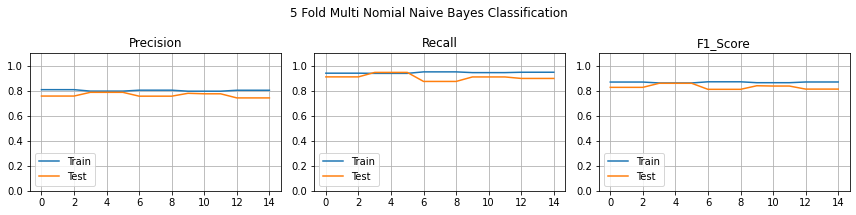

Model Bernoulli Naive Bayes Classification
Best F1 Score :  81.18093787007501 %


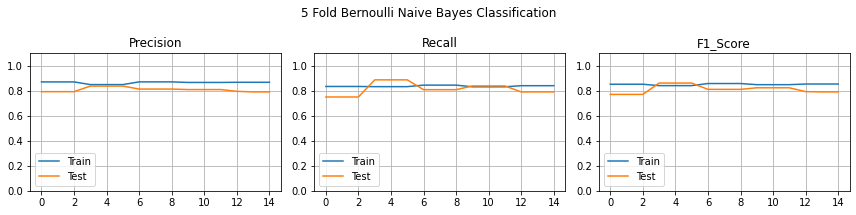

Model Complement Naive Bayes Classification
Best F1 Score :  78.99639156377908 %


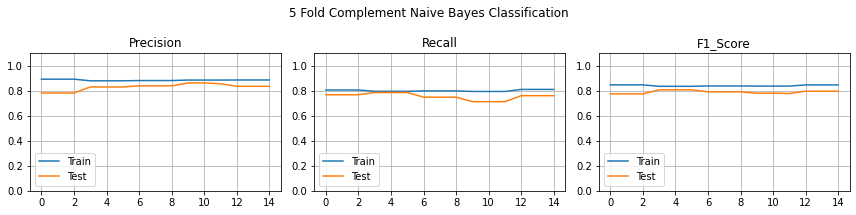

Model Logistic Regression
Best F1 Score :  83.38355208720233 %


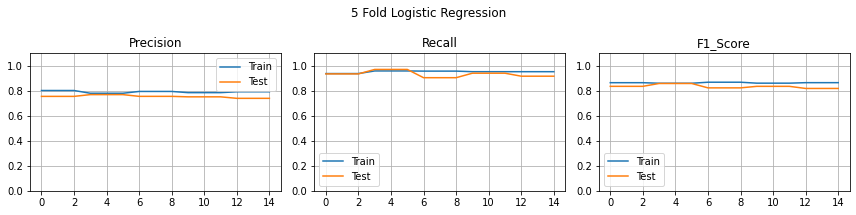

Model Nearest Centroid Classification
Best F1 Score :  78.96802068631305 %


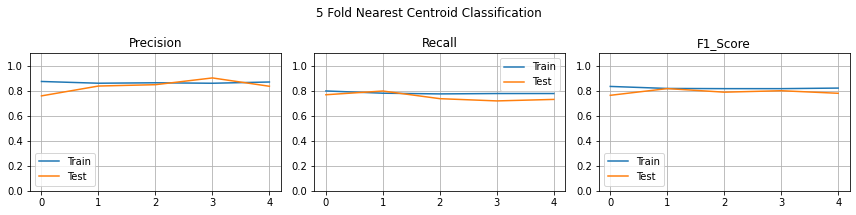

Model Ridge Classifier
Best F1 Score :  82.46977663180763 %


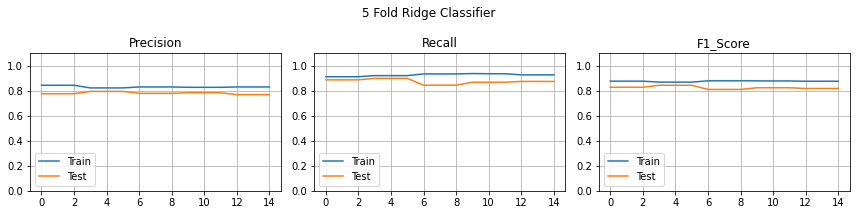

Model SGD Classifier
Best F1 Score :  83.78706576053465 %


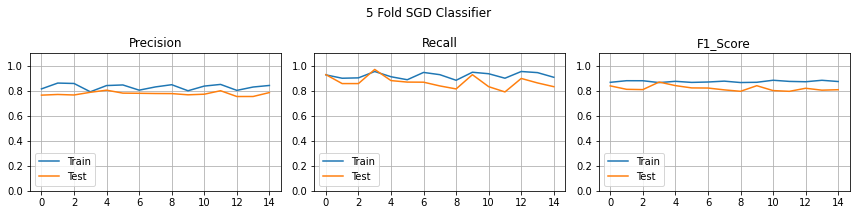

Model Linear SVC
Best F1 Score :  82.2937252276234 %


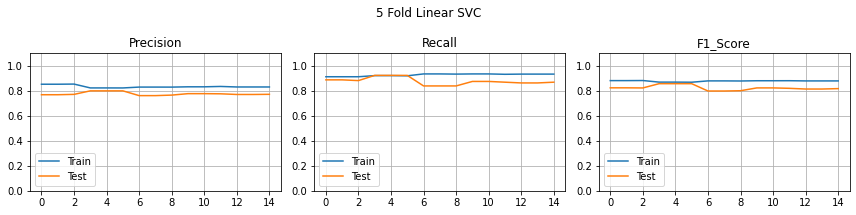

Model Random Forest Classifier
Best F1 Score :  82.44886342744593 %


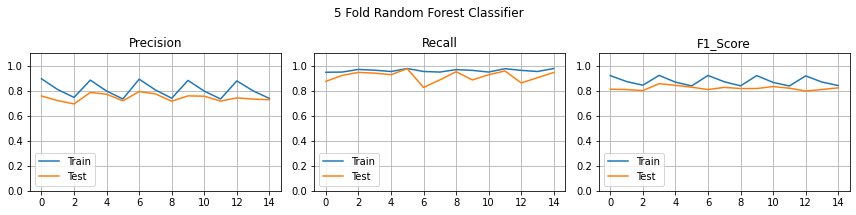

Model XGB Classifier


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:19:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 Score :  82.44444672949598 %


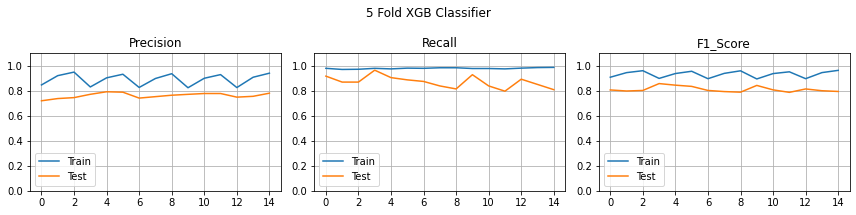

In [24]:
Results = {}
Results['5Fold'] = run_nfold(5, Models)

Model Multi Nomial Naive Bayes Classification
Best F1 Score :  83.49550904498638 %


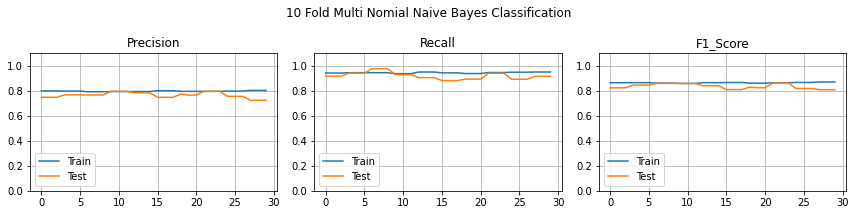

Model Bernoulli Naive Bayes Classification
Best F1 Score :  81.60794767322584 %


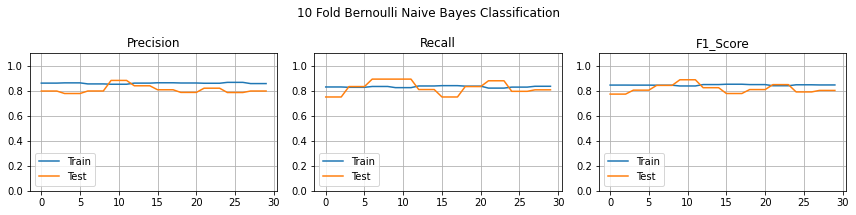

Model Complement Naive Bayes Classification
Best F1 Score :  79.50386320782971 %


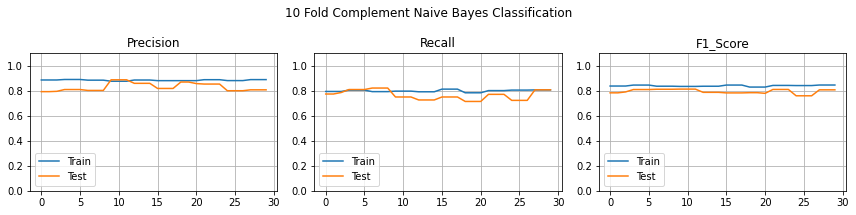

Model Logistic Regression
Best F1 Score :  82.64341246023672 %


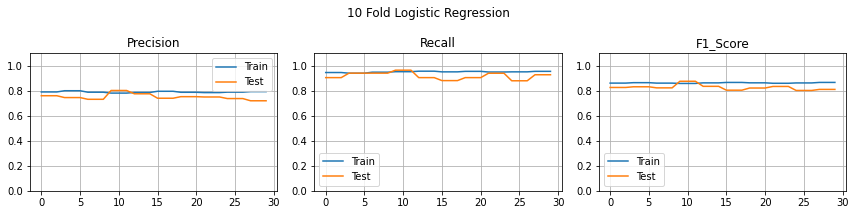

Model Nearest Centroid Classification
Best F1 Score :  79.28347286927297 %


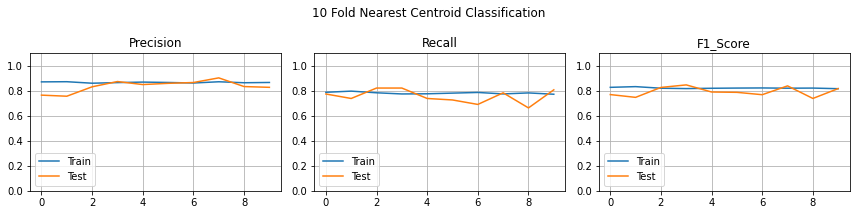

Model Ridge Classifier
Best F1 Score :  82.38379373077885 %


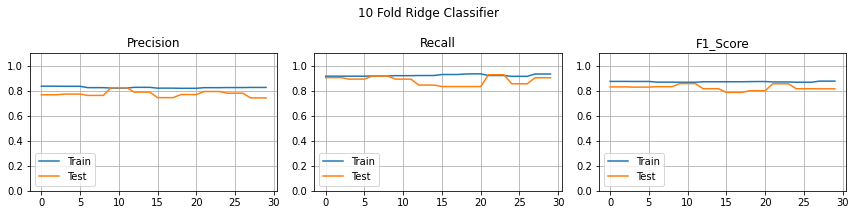

Model SGD Classifier
Best F1 Score :  83.5554483644307 %


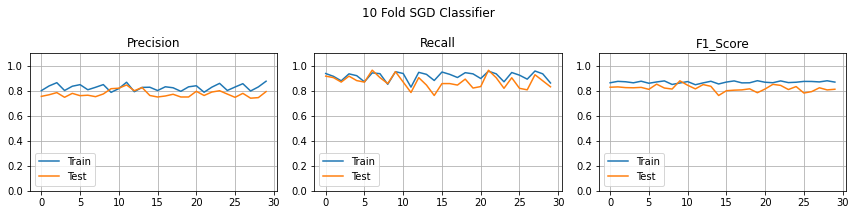

Model Linear SVC
Best F1 Score :  82.72837051570828 %


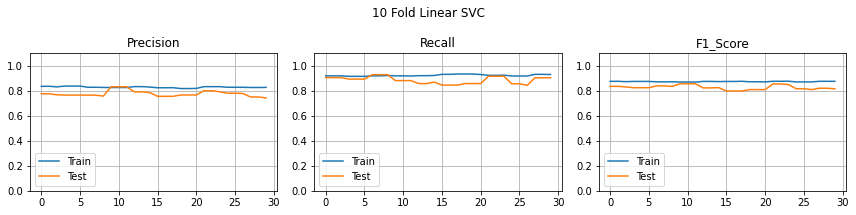

Model Random Forest Classifier
Best F1 Score :  82.50773908324427 %


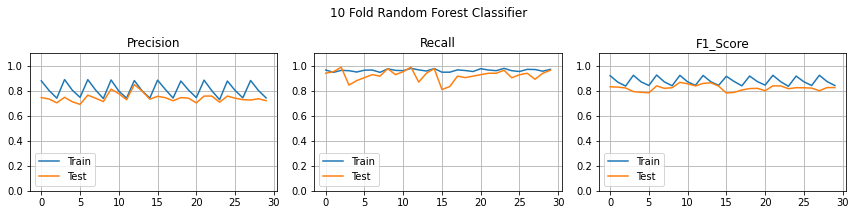

Model XGB Classifier


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:26:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best F1 Score :  82.58257562968026 %


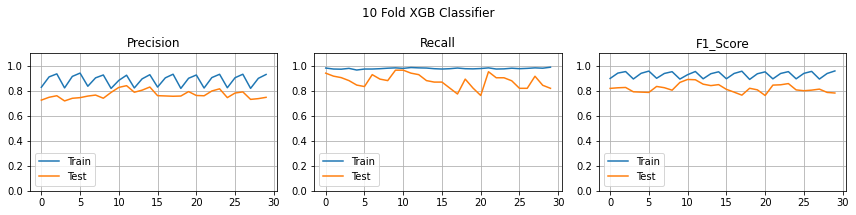

In [25]:
Results['10Fold'] = run_nfold(10, Models)

In [26]:
def convert_grid_search_to_df(nfold_result, name):
    res = {'Model':[],
           f'{name} Train F1 Score':[],
           f'{name} Test F1 Score':[],
           f'{name} Train Precision':[],
           f'{name} Test Precision':[],
           f'{name} Train Recall':[],
           f'{name} Test Recall':[],
           'Best Parameters':[]}
    for k in Models:
        res['Model'].append(k)
        iii = nfold_result[k].best_index_
        res[f'{name} Train F1 Score'].append(nfold_result[k].cv_results_['mean_train_F1_Score'][iii])
        res[f'{name} Test F1 Score'].append(nfold_result[k].cv_results_['mean_test_F1_Score'][iii])
        res[f'{name} Train Precision'].append(nfold_result[k].cv_results_['mean_train_Precision'][iii])
        res[f'{name} Test Precision'].append(nfold_result[k].cv_results_['mean_test_Precision'][iii])
        res[f'{name} Train Recall'].append(nfold_result[k].cv_results_['mean_train_Recall'][iii])
        res[f'{name} Test Recall'].append(nfold_result[k].cv_results_['mean_test_Recall'][iii])
        res['Best Parameters'].append(nfold_result[k].best_params_)
    df = pd.DataFrame(data=res)
    df.sort_values(by=f'{name} Test F1 Score', ascending=False, inplace=True)
    return df

In [27]:
fold_5 = convert_grid_search_to_df(Results['5Fold'], '5 Fold')
fold_10 = convert_grid_search_to_df(Results['10Fold'], '10 Fold')

In [28]:
fold_5

,Model,5 Fold Train F1 Score,5 Fold Test F1 Score,5 Fold Train Precision,5 Fold Test Precision,5 Fold Train Recall,5 Fold Test Recall,Best Parameters
6,SGD Classifier,0.868230,0.837871,0.802672,0.770562,0.945636,0.918684,{'alpha': 0.001}
3,Logistic Regression,0.863390,0.833836,0.790441,0.753800,0.951312,0.933048,{'tol': 0.001}
0,Multi Nomial Naive Bayes Classification,0.867373,0.830077,0.801951,0.764619,0.944441,0.907956,{'alpha': 0.001}
5,Ridge Classifier,0.875859,0.824698,0.830799,0.780398,0.926219,0.874508,{'alpha': 0.001}
8,Random Forest Classifier,0.869955,0.824489,0.801649,0.751437,0.951016,0.913951,{'min_samples_leaf': 5}
9,XGB Classifier,0.898602,0.824444,0.830378,0.750412,0.979092,0.915113,"{'eta': 0.1, 'objective': 'binary:logistic'}"
7,Linear SVC,0.877176,0.822937,0.833698,0.776301,0.925621,0.875684,{'tol': 0.1}
1,Bernoulli Naive Bayes Classification,0.850471,0.811809,0.864822,0.809443,0.836617,0.814806,{'alpha': 0.001}
2,Complement Naive Bayes Classification,0.840695,0.789964,0.884821,0.829756,0.800776,0.755026,{'alpha': 0.001}
4,Nearest Centroid Classification,0.821394,0.789680,0.865405,0.836494,0.781665,0.750221,{}


In [29]:
fold_10

,Model,10 Fold Train F1 Score,10 Fold Test F1 Score,10 Fold Train Precision,10 Fold Test Precision,10 Fold Train Recall,10 Fold Test Recall,Best Parameters
6,SGD Classifier,0.865644,0.835554,0.797395,0.765844,0.946765,0.919994,{'alpha': 0.001}
0,Multi Nomial Naive Bayes Classification,0.863927,0.834955,0.796402,0.765584,0.943978,0.918746,{'alpha': 0.001}
7,Linear SVC,0.873149,0.827284,0.828573,0.777969,0.922872,0.884137,{'tol': 0.01}
3,Logistic Regression,0.862485,0.826434,0.789527,0.751373,0.950351,0.918746,{'tol': 0.001}
9,XGB Classifier,0.894908,0.825826,0.823852,0.752806,0.979423,0.915175,"{'eta': 0.1, 'objective': 'binary:logistic'}"
8,Random Forest Classifier,0.921110,0.825077,0.883106,0.765970,0.962564,0.896113,{'min_samples_leaf': 2}
5,Ridge Classifier,0.871637,0.823838,0.826063,0.774683,0.922607,0.880579,{'alpha': 0.001}
1,Bernoulli Naive Bayes Classification,0.845588,0.816079,0.860001,0.809274,0.831675,0.824383,{'alpha': 0.001}
2,Complement Naive Bayes Classification,0.839311,0.795039,0.884102,0.828940,0.798883,0.765835,{'alpha': 1e-05}
4,Nearest Centroid Classification,0.821767,0.792835,0.866621,0.836296,0.781364,0.756254,{}
